## Tarea
Va a consistir de 4 pasos basados en lo que aprendimos de como manipular los INEGI shape files.

## Primero
#### Vas a escoger 5 estados y vas a graficar sus vecinos como vimos en el otro archivo. A cada uno de estos grupos los llamaremos grupos de estados.
#### Usa el shapefile de los estados


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon
from shapely.wkt import loads
import fiona
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

In [2]:
#Pon el path a tu shapefile de la carpeta de Estados que descargaste. Ejemplo:
file_pathAShapefile_Estados = '/home/jake3120/itam/FuentesDeDatos/INEGI-Shp_fork/ShapeFilesFiles/Estados/conjunto_de_datos/00ent.shp'
#Pon el path a tu shapefile de la carpeta de servicios_de_salud_shp que descargaste. Ejemplo:
file_pathAShapefile_ServicioSalud = '/home/jake3120/itam/FuentesDeDatos/INEGI-Shp_fork/ShapeFilesFiles/servicios_de_salud_shp/conjunto_de_datos/denue_inegi_62_.shp'
#Leer shapefiles que usaremos
gdf_mexico = gpd.read_file(file_pathAShapefile_Estados)
gdf_salud = gpd.read_file(file_pathAShapefile_ServicioSalud)

In [ ]:
vecinos_dict = {}
# Iterar sobre cada estado en el dataframe
for index, row in gdf_mexico.iterrows():
    # Obtener la geometría del estado actual
    estado_geom = row['geometry']
    
    # Encontrar los estados que intersectan con el estado actual (incluye fronteras y superposiciones)
    gdf_vecinos = gdf_mexico[gdf_mexico.geometry.intersects(estado_geom)]
    
    # Eliminar el estado mismo de la lista de vecinos (si se incluye)
    gdf_vecinos = gdf_vecinos[gdf_vecinos['NOMGEO'] != row['NOMGEO']]
    
    # Obtener los nombres de los vecinos
    vecinos_nombres = gdf_vecinos['NOMGEO'].tolist()
    
    # Almacenar en el diccionario
    vecinos_dict[row['NOMGEO']] = vecinos_nombres

# Ordenar el diccionario por el tamaño de las listas
ordenado_por_tamano = sorted(vecinos_dict.items(), key=lambda item: len(item[1]))

# Seleccionar los 5 mínimos
cinco_minimos = ordenado_por_tamano[:5]

# Crear un diccionario que almacene los resultados
resultado = {}
for pais, valores in cinco_minimos:
    resultado[pais] = {pais: valores}

estados_dict = list(resultado.keys())
estados_dict


['Jalisco', 'Michoacán de Ocampo', 'Colima'] 
 {'Baja California Sur': {'Baja California Sur': ['Baja California']}, 'Aguascalientes': {'Aguascalientes': ['Jalisco', 'Zacatecas']}, 'Baja California': {'Baja California': ['Baja California Sur', 'Sonora']}, 'Colima': {'Colima': ['Jalisco', 'Michoacán de Ocampo']}, 'Ciudad de México': {'Ciudad de México': ['México', 'Morelos']}}


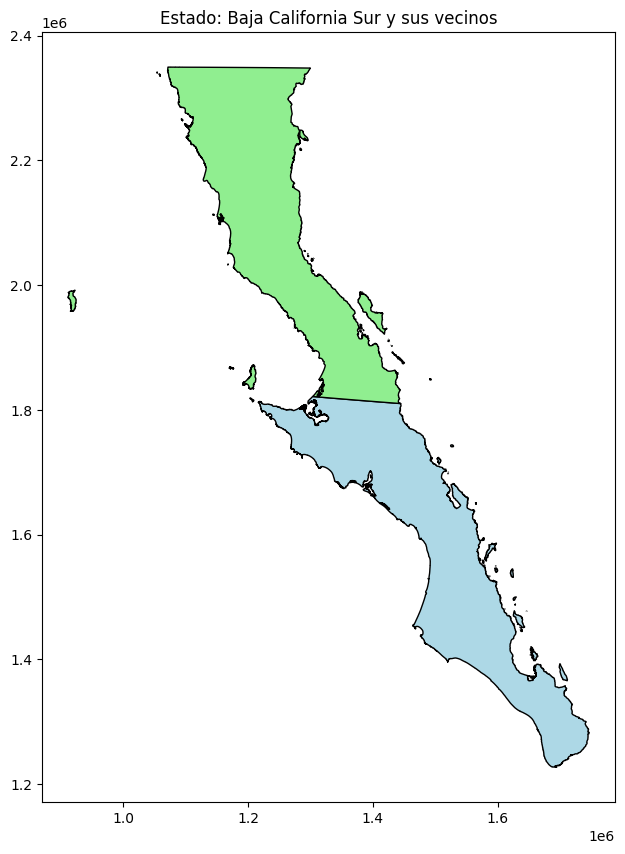

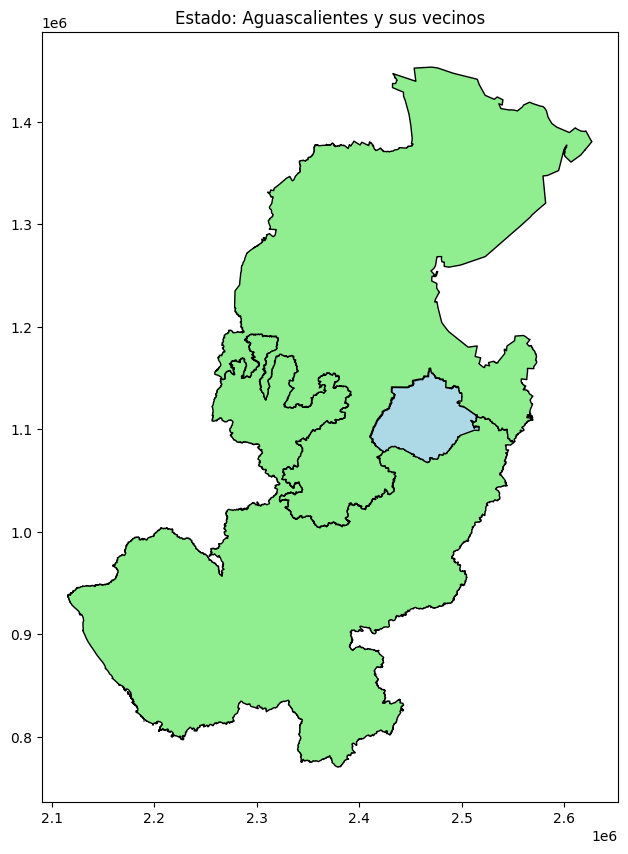

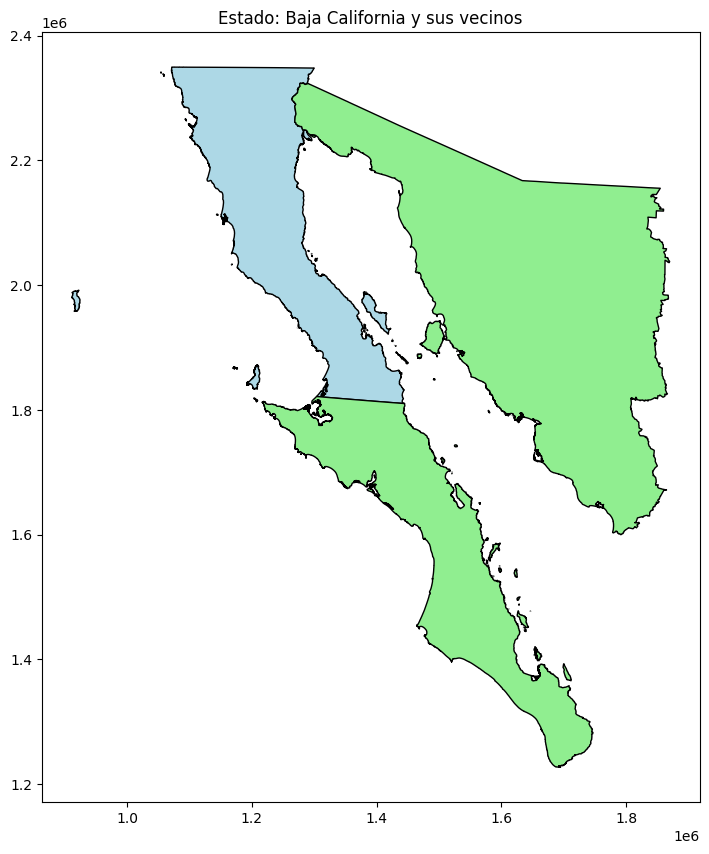

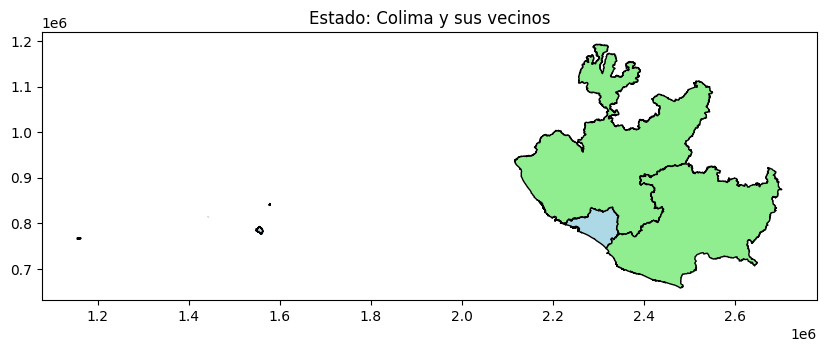

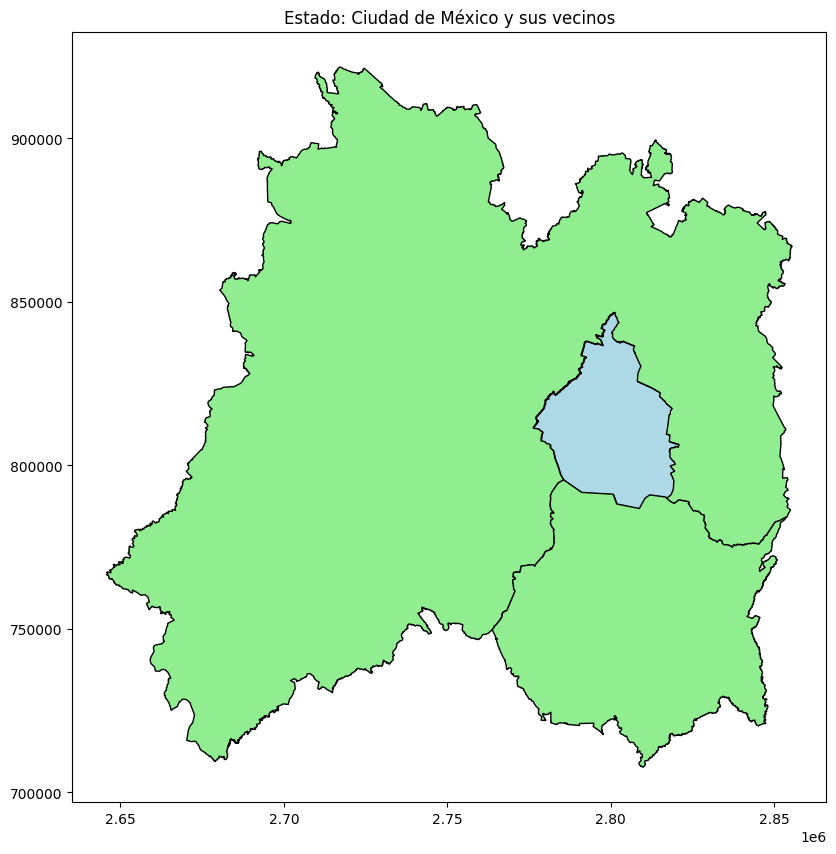

In [ ]:
def plot_estado_y_vecinos(estado, gdf, vecinos_dict):

    # Obtener los vecinos del estado desde el diccionario
    vecinos = vecinos_dict.get(estado, [])
    
    # Filtrar los estados vecinos
    gdf_vecinos = gdf[gdf['NOMGEO'].isin(vecinos)]
    
    # Crear una figura y un eje para el gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Graficar el estado de interés con un color especial (por ejemplo, en azul)
    gdf[gdf['NOMGEO'] == estado].plot(ax=ax, color='lightblue', edgecolor='black', label=f'{estado}')
    
    # Graficar los estados vecinos con otro color (por ejemplo, en verde)
    gdf_vecinos.plot(ax=ax, color='lightgreen', edgecolor='black', label='Vecinos')
    
    # Personalizar el gráfico
    ax.set_title(f"Estado: {estado} y sus vecinos")
    
    # Mostrar el gráfico
    plt.show()

for estado in estados_dict:
    plot_estado_y_vecinos(estado, gdf_mexico, vecinos_dict)

## Segundo
### En cada grupo de estados vas a graficar las farmacias que se encuentran en el área, al igual que un círculo a su alrededor que tenga un radio de igual longitud que la distancia de esa farmacia a la siguiente farmacia más cercana.

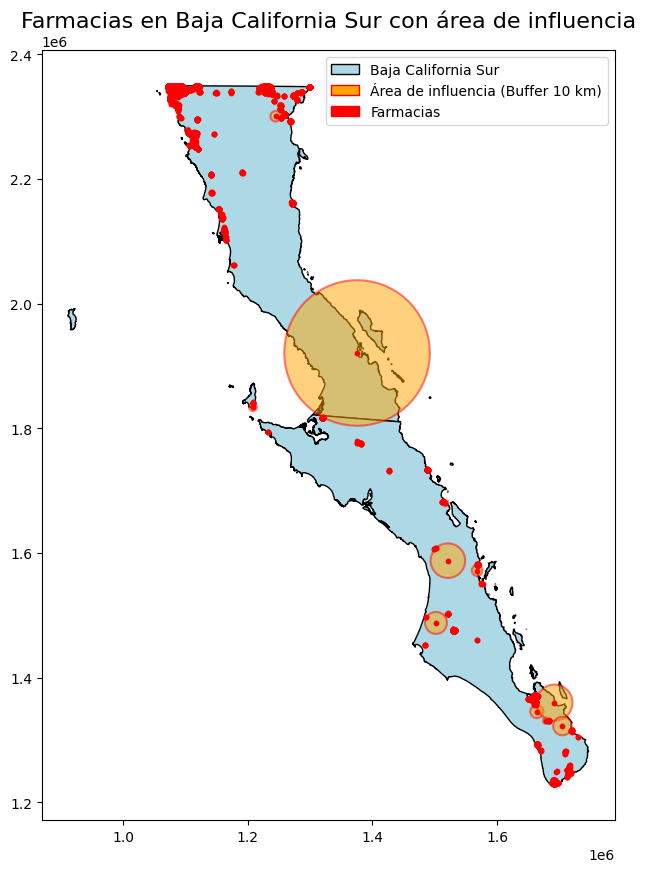

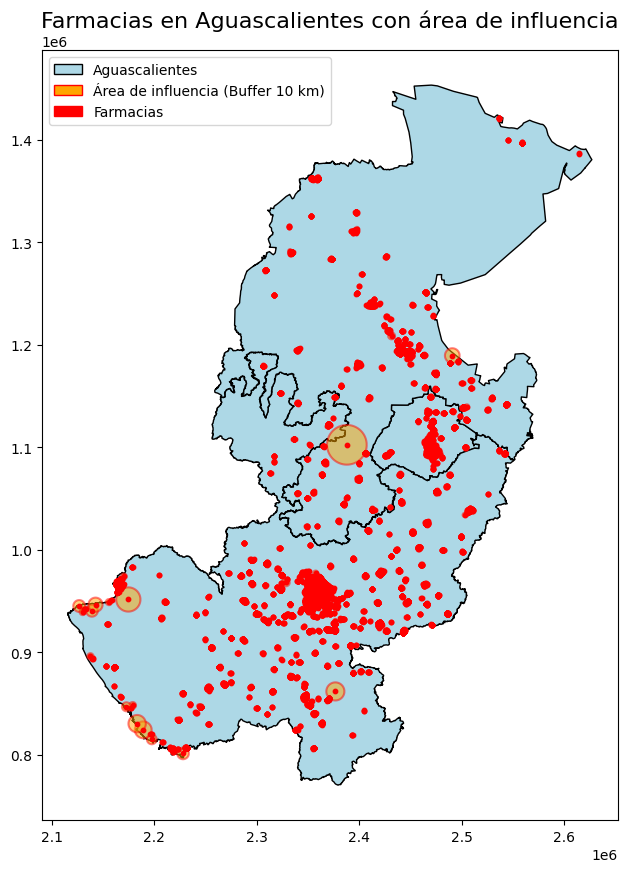

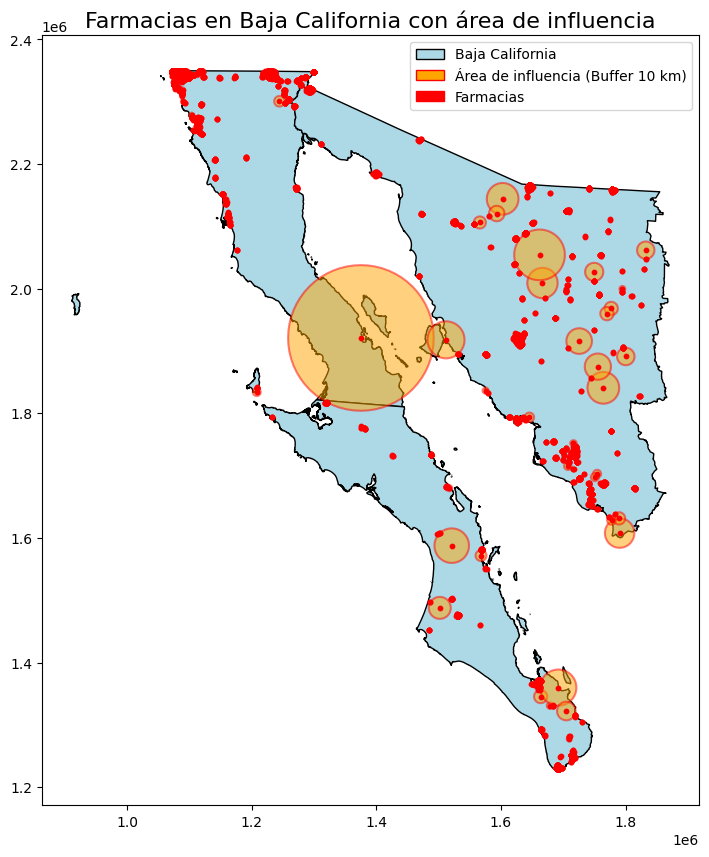

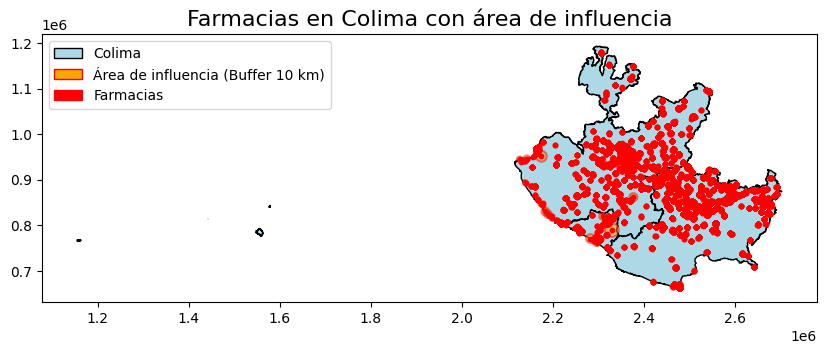

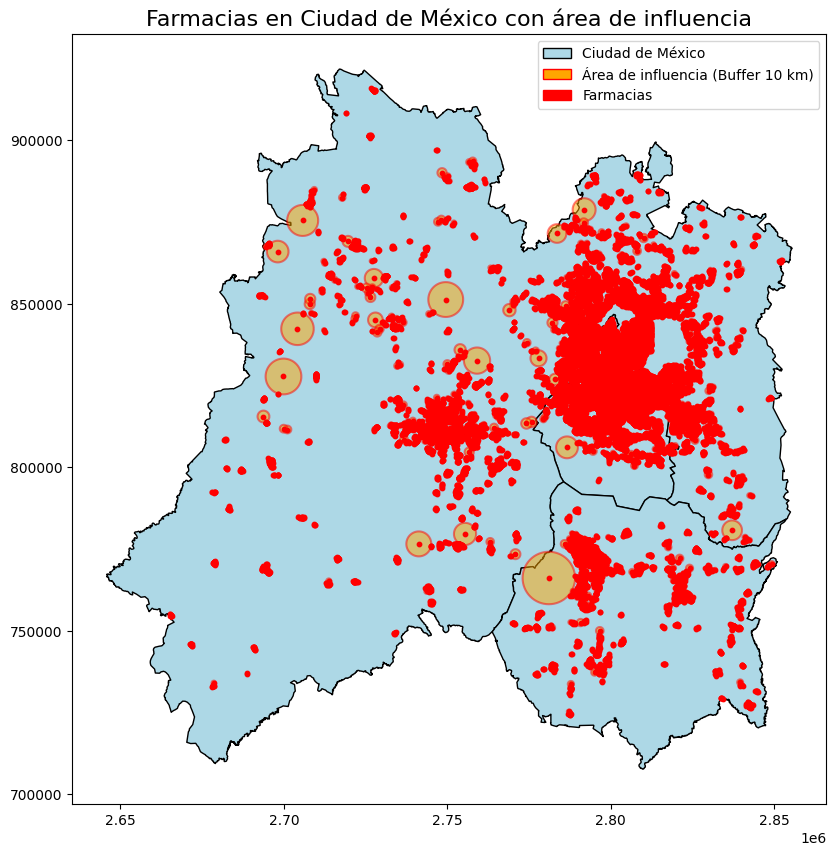

In [ ]:
def farmacias_estados_radio(entidad, gdf_salud, gdf_mexico):
    # Reproyectar las farmacias si los CRS no coinciden
    if gdf_mexico.crs != gdf_salud.crs:
        gdf_salud = gdf_salud.to_crs(gdf_mexico.crs)

    # Obtener los vecinos del estado desde el diccionario    
    vecinos = vecinos_dict.get(entidad, [])
    todo = vecinos + [entidad]
    
    # Filtrar el estado de interés
    gdf_entidad = gdf_mexico[gdf_mexico['NOMGEO'].isin(todo)]
    
 
    #Filt 
    gdf_farmacias_entidad = gdf_salud[gdf_salud['entidad'].isin(todo)].copy()
    

    # Crear una función para encontrar la geometría más cercana y calcular la distancia
    def nearest(row, other_gdf):
        other_geoms = other_gdf.geometry.drop(row.name)
        nearest_geom = nearest_points(row.geometry, other_geoms.union_all())[1]
        return nearest_geom.distance(row.geometry)

    # Calcular la distancia al vecino más cercano
    gdf_farmacias_entidad['nearest_dist'] = gdf_farmacias_entidad.apply(
        lambda row: nearest(row, gdf_farmacias_entidad), axis=1
    )

    # Crear un buffer con radio igual a la distancia más cercana
    gdf_farmacias_entidad['buffer'] = gdf_farmacias_entidad.apply(
        lambda row: row.geometry.buffer(row['nearest_dist']), axis=1
    )

    # Crear la figura y el eje para graficar
    fig, ax = plt.subplots(figsize=(10, 10))

    # Graficar el estado (en azul claro)
    gdf_entidad.plot(ax=ax, color='lightblue', edgecolor='black', label=f'{entidad}')

    # Graficar los buffers de las farmacias (en naranja)
    gdf_farmacias_entidad['buffer'].plot(ax=ax, color='orange', edgecolor='red', alpha=0.5, linewidth=1.5)

    # Graficar las farmacias como puntos (en rojo)
    gdf_farmacias_entidad.plot(ax=ax, color='red', markersize=10)

    # Crear leyenda personalizada
    from matplotlib.patches import Patch
    legend_patches = [
        Patch(facecolor='lightblue', edgecolor='black', label=f'{entidad}'),
        Patch(facecolor='orange', edgecolor='red', label='Área de influencia (Buffer 10 km)'),
        Patch(facecolor='red', edgecolor='red', label='Farmacias')
    ]
    ax.legend(handles=legend_patches)

    # Añadir título
    ax.set_title(f'Farmacias en {entidad} con área de influencia', fontsize=16)

    # Mostrar el gráfico
    plt.show()
    

for estado in estados_dict:
    farmacias_estados_radio(estado, gdf_salud, gdf_mexico)


## Tercero
### Por grupo de estados debes calcular cual es la farmacia que en promedio está más alejada de el resto de farmacias.
### Debes graficar las distancias de esta farmacia al resto de las farmacias en el grupo de estados.

/tmp/ipykernel_61553/3012992618.py:55: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


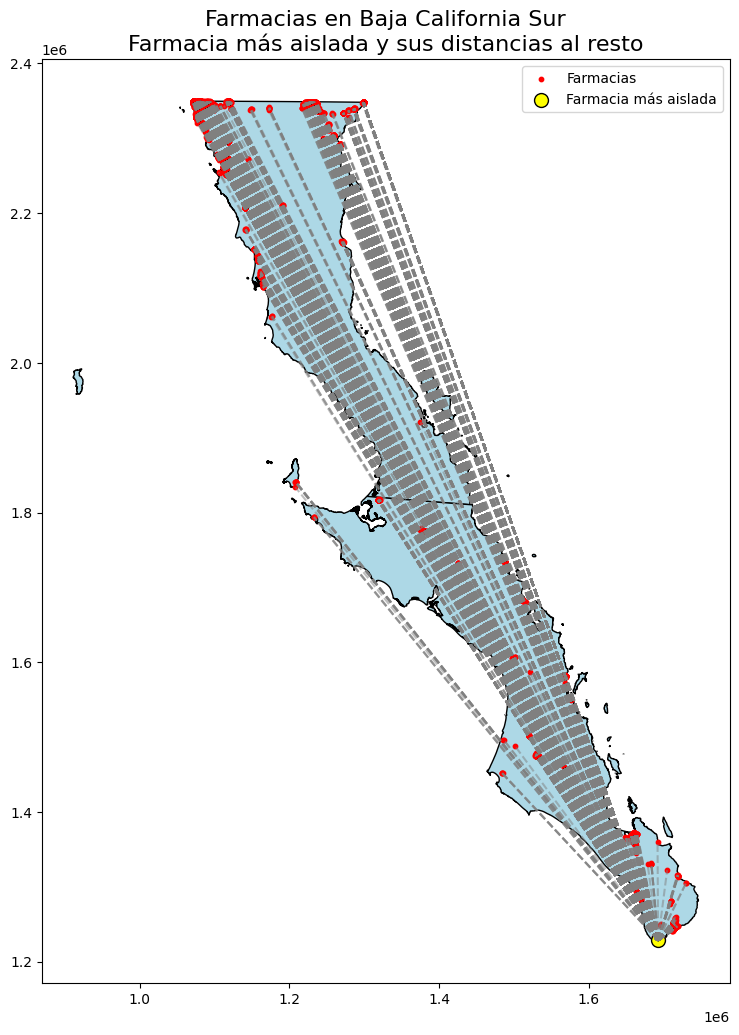

: 

In [5]:
def farmacias_estados_promedio(entidad, gdf_salud, gdf_mexico):
    # Reproyectar las farmacias si los CRS no coinciden
    if gdf_mexico.crs != gdf_salud.crs:
        gdf_salud = gdf_salud.to_crs(gdf_mexico.crs)

    # Obtener los vecinos del estado desde el diccionario    
    vecinos = vecinos_dict.get(entidad, [])
    todo = vecinos + [entidad]
    
    # Filtrar el estado de interés
    gdf_entidad = gdf_mexico[gdf_mexico['NOMGEO'].isin(todo)]
    gdf_farmacias_entidad = gdf_salud[gdf_salud['entidad'].isin(todo)].copy()

    # Calcular las distancias entre todas las farmacias
    def calcular_distancias(gdf):
        distancias = []
        for i, row in gdf.iterrows():
            otras_geometrías = gdf.geometry.drop(i)
            distancias.append(otras_geometrías.distance(row.geometry).tolist())
        return distancias

    # Añadir columna de distancias al GeoDataFrame
    gdf_farmacias_entidad['distancias'] = calcular_distancias(gdf_farmacias_entidad)
    
    # Calcular el promedio de distancias para cada farmacia
    gdf_farmacias_entidad['promedio_dist'] = gdf_farmacias_entidad['distancias'].apply(lambda d: sum(d) / len(d))

    # Identificar la farmacia con el mayor promedio de distancia
    farmacia_mas_aislada = gdf_farmacias_entidad.loc[gdf_farmacias_entidad['promedio_dist'].idxmax()]

    # Graficar el estado y las farmacias
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf_entidad.plot(ax=ax, color='lightblue', edgecolor='black', label=f'{entidad}')
    gdf_farmacias_entidad.plot(ax=ax, color='red', markersize=10, label='Farmacias')
    
    # Graficar la farmacia más aislada en amarillo
    ax.scatter(
        farmacia_mas_aislada.geometry.x, 
        farmacia_mas_aislada.geometry.y, 
        color='yellow', 
        label='Farmacia más aislada', 
        s=100, 
        edgecolor='black'
    )
    
    # Graficar las distancias de la farmacia más aislada al resto
    for distancia, geometría in zip(farmacia_mas_aislada['distancias'], gdf_farmacias_entidad.geometry):
        ax.plot(
            [farmacia_mas_aislada.geometry.x, geometría.x],
            [farmacia_mas_aislada.geometry.y, geometría.y],
            linestyle='--', color='gray', alpha=0.5
        )

    # Añadir leyenda y título
    ax.legend()
    ax.set_title(f'Farmacias en {entidad}\nFarmacia más aislada y sus distancias al resto', fontsize=16)

    # Mostrar el gráfico
    plt.show()
    
for estado in estados_dict:
    farmacias_estados_promedio(estado, gdf_salud, gdf_mexico)

## Cuarto
### Calcula cual es el grupo de estados con mayor distancia promedio entre sus farmacias.
### Luego grafica el país completo con el shapefile de estados y grafica el grupo de estados con mayor distancia promedio entre farmacias de un color distinto.

In [ ]:
def farmacias_estados_p4(entidad, gdf_salud, gdf_mexico):
    # Reproyectar las farmacias si los CRS no coinciden
    if gdf_mexico.crs != gdf_salud.crs:
        gdf_salud = gdf_salud.to_crs(gdf_mexico.crs)

    # Obtener los vecinos del estado desde el diccionario    
    vecinos = vecinos_dict.get(entidad, [])
    todo = vecinos + [entidad]
    
    # Filtrar el estado de interés
    gdf_entidad = gdf_mexico[gdf_mexico['NOMGEO'].isin(todo)]
    
    # Filtrar farmacias en el grupo de estados
    gdf_farmacias_entidad = gdf_salud[gdf_salud['entidad'].isin(todo)].copy()

    # Crear una matriz de distancias entre todas las farmacias
    coords = np.array(list(gdf_farmacias_entidad.geometry.apply(lambda geom: (geom.x, geom.y))))
    distance_matrix = np.sqrt(np.sum((coords[:, np.newaxis] - coords[np.newaxis, :]) ** 2, axis=-1))

    # Calcular la distancia promedio (excluyendo la diagonal de ceros)
    avg_distance = np.sum(distance_matrix) / (len(coords) * (len(coords) - 1))
    # Devolver la distancia promedio
    return avg_distance

def estado_max_dist_prom(DistProm_estados):

    if not DistProm_estados:
        return None, None  # Manejo de casos donde el diccionario está vacío

    # Encontrar el estado con la mayor distancia promedio
    estado_max = max(DistProm_estados, key=DistProm_estados.get)
    max_dist = DistProm_estados[estado_max]

    return estado_max, max_dist


DistProm_estados = {}

# Iterar sobre los estados en el diccionario
for estado in estados_dict:

    DistProm_estados[estado] = farmacias_estados_p4(estado, gdf_salud, gdf_mexico)





: 

In [24]:

def farmacias_estados_p4(entidad, gdf_salud, gdf_mexico, vecinos_dict):
    # Reproyectar las farmacias si los CRS no coinciden
    if gdf_mexico.crs != gdf_salud.crs:
        gdf_salud = gdf_salud.to_crs(gdf_mexico.crs)

    # Obtener los vecinos del estado desde el diccionario    
    vecinos = vecinos_dict.get(entidad, [])
    todo = vecinos + [entidad]
    
    # Filtrar el estado de interés
    gdf_entidad = gdf_mexico[gdf_mexico['NOMGEO'].isin(todo)]
    
    # Filtrar farmacias en el grupo de estados
    gdf_farmacias_entidad = gdf_salud[gdf_salud['entidad'].isin(todo)].copy()

    # Crear una matriz de distancias entre todas las farmacias
    coords = np.array(list(gdf_farmacias_entidad.geometry.apply(lambda geom: (geom.x, geom.y))))
    distance_matrix = np.sqrt(np.sum((coords[:, np.newaxis] - coords[np.newaxis, :]) ** 2, axis=-1))

    # Calcular la distancia promedio (excluyendo la diagonal de ceros)
    avg_distance = np.sum(distance_matrix) / (len(coords) * (len(coords) - 1)) if len(coords) > 1 else 0
    return avg_distance

def estado_max_dist_prom(DistProm_estados):
    if not DistProm_estados:
        return None, None  # Manejo de casos donde el diccionario está vacío

    # Encontrar el estado con la mayor distancia promedio
    estado_max = max(DistProm_estados, key=DistProm_estados.get)
    max_dist = DistProm_estados[estado_max]

    return estado_max, max_dist

def plot_estado_y_vecinos(estado, gdf, vecinos_dict):
    # Obtener los vecinos del estado
    vecinos = vecinos_dict.get(estado, [])
    vecinos.append(estado)
    vecinos = list(set(vecinos))

    # Filtrar los estados vecinos
    gdf_vecinos = gdf[gdf['NOMGEO'].isin(vecinos)]
    
    # Crear una figura y un eje para el gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Graficar el estado de interés con un color especial (por ejemplo, en azul)
    gdf[gdf['NOMGEO'] == estado].plot(ax=ax, color='lightblue', edgecolor='black', label=f'{estado}')
    
    # Graficar los estados vecinos con otro color (por ejemplo, en verde)
    gdf_vecinos.plot(ax=ax, color='lightgreen', edgecolor='black', label='Vecinos')
    
    # Personalizar el gráfico
    ax.set_title(f"Estado: {estado} y sus vecinos")
    ax.legend()
    plt.show()

def plot_pais_y_max_distancia(gdf_mexico, DistProm_estados, vecinos_dict):
    # Encontrar el estado con la mayor distancia promedio
    estado_max, _ = estado_max_dist_prom(DistProm_estados)
    
    # Obtener el grupo de estados vecinos del estado con la mayor distancia promedio
    vecinos = vecinos_dict.get(estado_max, [])
    grupo_max_dist = [estado_max] + vecinos

    # Graficar el país completo
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf_mexico.plot(ax=ax, color='lightgray', edgecolor='black', label='Resto del país')
    
    # Graficar el grupo de estados con la mayor distancia promedio en un color especial
    gdf_mexico[gdf_mexico['NOMGEO'].isin(grupo_max_dist)].plot(ax=ax, color='orange', edgecolor='black', label='Grupo con mayor distancia promedio')
    
    # Personalizar el gráfico
    ax.set_title("Mapa de México con el grupo de estados con mayor distancia promedio entre farmacias")
    ax.legend()
    plt.show()

# Cálculo de distancia promedio por estado
DistProm_estados = {}
for estado in vecinos_dict:
    DistProm_estados[estado] = farmacias_estados_p4(estado, gdf_salud, gdf_mexico, vecinos_dict)

# Gráfico del país y el grupo con mayor distancia promedio
plot_pais_y_max_distancia(gdf_mexico, DistProm_estados, vecinos_dict)

: 